# 1D Three Phase Simulation of Alloys and PINN model development 


This notebook contains the simulation of 1D Phase change of aluminium alloy. There will be three phases (solid,liquid and mushy).   

The approach used is finite difference method and the physics involved in heat conduction.

## Import Libraries

In [1]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools

import mqr
from mqr.plot import Figure
from mqr.nbtools import hstack, vstack, grab_figure

from mqr.doe import Design

from ht_simNy import sim1d



from pyDOE2 import fullfact
from pyDOE2 import fracfact

import statsmodels.api as sm

from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize


### <center>Pareto analysis</center>

<p style="font-size:12px; font-family:'Times New Roman', sans-serif; line-height:1.6;">

In this section sensitivity study of the soldification is performed with respect to different material properties and  initial/boundary conditions. The soldification time is the variable under study and it is calcualted based on solution of 1D heat transfer and phase change equation.



Here the parameters/factors are as follows:-

1. Density for material in liquid state $\rho_l$.<br>
2. Density for material in solid state $\rho_s$.<br>
3. Latent Heat of Fusion <br>
4. Specific heat of material in liquid state $C_{pl}$ <br>
5. Specific heat of material in solid state $C_{ps}$ <br>
6. Thermal Conductivity of material in liquid state $k_l$<br>
7. Thermal Conductivity of material in solid state $k_s$ <br>


Boundary conditions:-
8. Surrounding Temperature <br>

Initial Conditions:-

9. Initial_temperature <br>


</p>




The number of runs are large so a fractional factorial design is adopted.

## Fractional Factorial Design

In [2]:
#Create a fractional factorial design

from pyDOE2 import fracfact

num_levels = 2
levels = [0, 1]
num_vars = 11
design2 = fracfact('a b c d e f g abc abd ace bcf cde')
L_level = 0.99
R_level = 1.01
perc_change = [0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.3, 0.03, 0.60, 0.30,0.30]


factor_levels = {
    'rho_l': [2386.20, 2533.8], #A
    'rho_s': [2628.70, 2791.3], #B
    'k_l': [100.88, 107.2],    #C
    'k_s': [93.31,99.08],      #D
    'cp_l': [1207.94, 1282.65], #E
    'cp_s': [934.11, 991.89],  #F
    'Surr_temp': [285.0,298.0], #G
    'L_fusion': [377330,400670], #H
    'temp_init': [901.0, 925.0], # J
    'heat_transfer_coefficient_left': [10.0, 15.0], #K
    'heat_transfer_coefficient_right': [10.0, 15.0], #L
    'Length': [10.0e-3, 20.0e-3],      #M
}


factor_names = list(factor_levels.keys())
# print (313.0 *(1+perc_change[6]))
# Create a DataFrame from the fractional factorial design
doe_df_sol_time_fracfact = pd.DataFrame(design2, columns=factor_names)

for factor, levels in factor_levels.items():
    doe_df_sol_time_fracfact[factor] = doe_df_sol_time_fracfact[factor].map({-1: levels[0], 1: levels[1]})
   
    
print(design2)

[[-1. -1. -1. ... -1. -1. -1.]
 [ 1. -1. -1. ...  1. -1. -1.]
 [-1.  1. -1. ... -1.  1. -1.]
 ...
 [ 1. -1.  1. ...  1. -1.  1.]
 [-1.  1.  1. ... -1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]]


In [26]:
# import csv file

des3 = pd.read_csv('cp_design.csv')


cp_des = des3.drop(des3.columns[:4],axis=1)

cp_tab = cp_des.to_numpy()

doe_cp = pd.DataFrame(cp_tab, columns=factor_names)

for factor, levels in factor_levels.items():
    doe_cp[factor] = doe_cp[factor].map({-1: levels[0], 1: levels[1]})

c_point = {factor: np.mean(levels) for factor,levels in factor_levels.items()}
center_point = np.array(list(c_point.values()))
# print(center_point.shape)

doe_cp[-1:] = center_point



doe_cp['Lowest_Niyama'] = [0.0] * doe_cp.shape[0]





print(doe_cp)


      rho_l   rho_s     k_l     k_s      cp_l    cp_s  Surr_temp  L_fusion  \
0    2386.2  2628.7  100.88  93.310  1207.940  934.11      285.0  400670.0   
1    2533.8  2628.7  100.88  93.310  1207.940  934.11      285.0  377330.0   
2    2386.2  2791.3  100.88  93.310  1207.940  934.11      285.0  400670.0   
3    2533.8  2791.3  100.88  93.310  1207.940  934.11      285.0  377330.0   
4    2386.2  2628.7  107.20  93.310  1207.940  934.11      285.0  377330.0   
..      ...     ...     ...     ...       ...     ...        ...       ...   
124  2386.2  2628.7  107.20  99.080  1282.650  991.89      298.0  377330.0   
125  2533.8  2628.7  107.20  99.080  1282.650  991.89      298.0  400670.0   
126  2386.2  2791.3  107.20  99.080  1282.650  991.89      298.0  377330.0   
127  2533.8  2791.3  107.20  99.080  1282.650  991.89      298.0  400670.0   
128  2460.0  2710.0  104.04  96.195  1245.295  963.00      291.5  389000.0   

     temp_init  heat_transfer_coefficient_left  \
0        925.

In [4]:
for i in range(doe_cp.shape[0]):
    input_values = doe_cp.iloc[i,:-1].values
    k= sim1d(*input_values)
    doe_cp.at[i, 'Lowest_Niyama'] = k

(9052, 48)
Lowest Niyama:6.26, rho_l:2386.2, rho_s:2628.7, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:400670.0, temp_init:925.0,htc_l:15.0,htc_r:15.0,length:0.02
(10265, 48)
Lowest Niyama:0.01, rho_l:2533.8, rho_s:2628.7, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:377330.0, temp_init:901.0,htc_l:15.0,htc_r:10.0,length:0.02
(12302, 48)
Lowest Niyama:4.61, rho_l:2386.2, rho_s:2791.3, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:400670.0, temp_init:901.0,htc_l:10.0,htc_r:10.0,length:0.02
(10373, 48)
Lowest Niyama:0.01, rho_l:2533.8, rho_s:2791.3, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:377330.0, temp_init:925.0,htc_l:10.0,htc_r:15.0,length:0.02
(18473, 48)
Lowest Niyama:0.33, rho_l:2386.2, rho_s:2628.7, k_l:107.2, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:377330.0, temp_init:901.0,htc_l:10.0,htc_r:15.0,length:0.01
(25551, 48)
Lowest Niyama:5.04, rho_l

In [5]:
doe_cp.to_csv('cp_result.csv', index=False)

In [6]:
doe_cp['center_pt'] = [0] * doe_cp.shape[0]

doe_cp.at[doe_cp.shape[0]-1, 'center_pt'] = 1



In [7]:
formula5 = 'Lowest_Niyama ~  center_pt + rho_l + rho_s + k_l + k_s \
             + cp_l + cp_s + Surr_temp + L_fusion + temp_init + \
            heat_transfer_coefficient_left + heat_transfer_coefficient_right + Length + \
            rho_l*rho_s + rho_l*k_l + rho_l*cp_l + rho_l*cp_s + rho_l*Surr_temp + rho_l*L_fusion + rho_l*heat_transfer_coefficient_left + \
             + rho_l*Length + rho_s*k_l + rho_s*cp_l + \
            rho_s*cp_s +  \
            rho_s*heat_transfer_coefficient_right + rho_s*Length + k_l*cp_l  + k_l*Surr_temp + k_l*L_fusion +\
             + k_l*heat_transfer_coefficient_left  + k_l*Length + k_s*cp_l  + \
            k_s*Surr_temp + k_s*heat_transfer_coefficient_left +  \
            cp_l*cp_s + cp_l*Surr_temp + cp_l*L_fusion + cp_l*temp_init + cp_l*heat_transfer_coefficient_left + \
            cp_l*Length +  cp_s*L_fusion + cp_s*temp_init + cp_s*heat_transfer_coefficient_left + cp_s*heat_transfer_coefficient_right + \
            cp_s*Length + Surr_temp*L_fusion + Surr_temp*temp_init +  \
            Surr_temp*Length + L_fusion*heat_transfer_coefficient_right + L_fusion*Length + \
            + heat_transfer_coefficient_left*heat_transfer_coefficient_right + \
            heat_transfer_coefficient_left*Length + heat_transfer_coefficient_right*Length'

model_cp = sm.OLS.from_formula(formula5, data=doe_cp.iloc[:-1]).fit()

mqr.anova.coeffs(model_cp)

/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,Coeff,[2.5%,97.5%],t,PR(>|t|),VIF
Intercept,-3.247781e+02,-8.741732e+02,2.246169e+02,-1.177643,2.426624e-01,5.310933e+07
center_pt,7.903756e-02,5.043365e-02,1.076415e-01,5.504523,4.945557e-07,NaN
rho_l,-2.554617e-01,-3.443675e-01,-1.665560e-01,-5.724105,2.024094e-07,7.574844e+03
rho_s,1.283929e-01,6.651810e-02,1.902676e-01,4.133700,9.204300e-05,4.452555e+03
k_l,7.123796e-01,-1.209663e+00,2.634422e+00,0.738346,4.626084e-01,6.490851e+03
k_s,-4.037450e-01,-1.869990e+00,1.062500e+00,-0.548545,5.849471e-01,3.148518e+03
cp_l,7.222936e-01,4.794868e-01,9.651003e-01,5.926041,8.808824e-08,1.447505e+04
cp_s,-8.807554e-01,-1.145502e+00,-6.160089e-01,-6.627303,4.599142e-09,1.029335e+04
Surr_temp,-4.244193e-02,-1.276861e+00,1.191977e+00,-0.068493,9.455757e-01,1.132800e+04
L_fusion,-1.659655e-04,-6.853276e-04,3.533965e-04,-0.636589,5.263306e-01,6.463733e+03



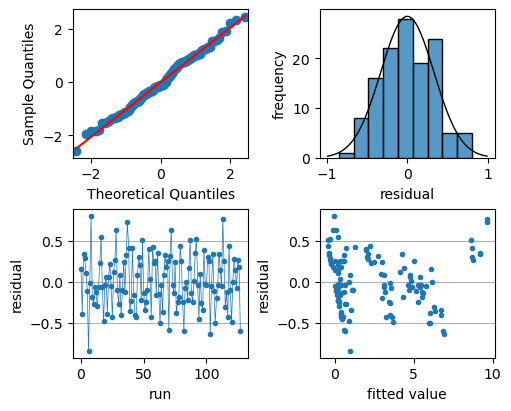

In [8]:
with Figure(5, 4, 2, 2) as (fig, ax):
    mqr.plot.regression.residuals(model_cp, axs=ax)
    plot = grab_figure(fig)

hstack(
    plot,
    vstack(
        mqr.anova.adequacy(model_cp),
        mqr.inference.dist.test_1sample(model_cp.resid)
    )
)


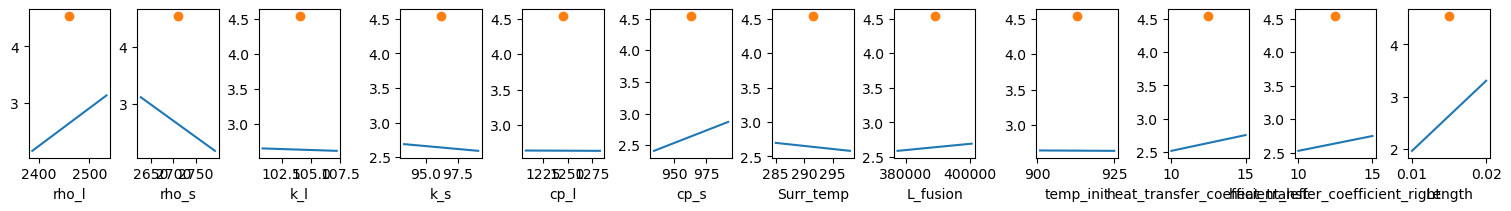

In [9]:
effect = 'Lowest_Niyama'
var_list = doe_cp.columns[0:12]

cornerdata = doe_cp.query('center_pt == 0')
centerdata = doe_cp.query('center_pt == 1')

with Figure(15, 2, 1, len(var_list)) as (fig, axs):
    for name, ax in zip(var_list, axs):
        ax.plot(cornerdata.groupby(name).mean()[effect], color='C0')
        ax.plot(centerdata.groupby(name).mean()[effect], color='C1', marker='o')
        ax.set_xlabel(name)
        plot1 = grab_figure(fig)

plot1

In [10]:



axial_points = []

alpha = 1.414

# Calculate the midpoint (center) for each factor
factor_centers = {key: (low + high) / 2 for key, (low, high) in factor_levels.items()}

for factor in factor_levels.keys():
    for direction in [-1,1]:
        axial_point = factor_centers.copy()
        low , high = factor_levels[factor]

        if direction == 1:
            axial_point[factor] = factor_centers[factor] + alpha * (high - factor_centers[factor])
        else:
            axial_point[factor] = factor_centers[factor] - alpha * (factor_centers[factor] - low)
        
        axial_points.append(axial_point)
    


axial_df = pd.DataFrame(axial_points, columns=factor_centers.keys())

print(axial_df.shape)


axial_df['Lowest_Niyama'] = [0.0] * axial_df.shape[0]
axial_df['center_pt'] = [0.0] * axial_df.shape[0]
print(axial_df.shape)
print(doe_cp.shape)
doe_axial = pd.concat([doe_cp, axial_df], axis=0,ignore_index=True)
print(doe_axial.tail())






(24, 12)
(24, 14)
(129, 14)
      rho_l   rho_s     k_l     k_s      cp_l   cp_s  Surr_temp  L_fusion  \
148  2460.0  2710.0  104.04  96.195  1245.295  963.0      291.5  389000.0   
149  2460.0  2710.0  104.04  96.195  1245.295  963.0      291.5  389000.0   
150  2460.0  2710.0  104.04  96.195  1245.295  963.0      291.5  389000.0   
151  2460.0  2710.0  104.04  96.195  1245.295  963.0      291.5  389000.0   
152  2460.0  2710.0  104.04  96.195  1245.295  963.0      291.5  389000.0   

     temp_init  heat_transfer_coefficient_left  \
148      913.0                          16.035   
149      913.0                          12.500   
150      913.0                          12.500   
151      913.0                          12.500   
152      913.0                          12.500   

     heat_transfer_coefficient_right   Length  Lowest_Niyama  center_pt  
148                           12.500  0.01500            0.0        0.0  
149                            8.965  0.01500            0.0

In [11]:
counter = 0
for i in range(doe_axial.shape[0]):
    input_values = doe_axial.iloc[i,:-2].values
    k= sim1d(*input_values)
    doe_axial.at[i, 'Lowest_Niyama'] = k
    counter += 1
    print(counter)

(9052, 48)
Lowest Niyama:6.26, rho_l:2386.2, rho_s:2628.7, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:400670.0, temp_init:925.0,htc_l:15.0,htc_r:15.0,length:0.02
1
(10265, 48)
Lowest Niyama:0.01, rho_l:2533.8, rho_s:2628.7, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:377330.0, temp_init:901.0,htc_l:15.0,htc_r:10.0,length:0.02
2
(12302, 48)
Lowest Niyama:4.61, rho_l:2386.2, rho_s:2791.3, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:400670.0, temp_init:901.0,htc_l:10.0,htc_r:10.0,length:0.02
3
(10373, 48)
Lowest Niyama:0.01, rho_l:2533.8, rho_s:2791.3, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:377330.0, temp_init:925.0,htc_l:10.0,htc_r:15.0,length:0.02
4
(18473, 48)
Lowest Niyama:0.33, rho_l:2386.2, rho_s:2628.7, k_l:107.2, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:377330.0, temp_init:901.0,htc_l:10.0,htc_r:15.0,length:0.01
5
(25551, 48)
Lowest Niyama:5

In [12]:
formula11 = 'Lowest_Niyama ~ rho_l + rho_s + k_l + k_s \
             + cp_l + cp_s + Surr_temp + L_fusion + temp_init + \
            heat_transfer_coefficient_left + heat_transfer_coefficient_right + Length + \
            rho_l*rho_s + rho_l*k_l + rho_l*cp_l + rho_l*cp_s + rho_l*Surr_temp + rho_l*L_fusion + rho_l*heat_transfer_coefficient_left + \
             + rho_l*Length + rho_s*k_l + rho_s*cp_l + \
            rho_s*cp_s + rho_s*Surr_temp + rho_s*L_fusion  + rho_s*heat_transfer_coefficient_left + \
            rho_s*heat_transfer_coefficient_right + rho_s*Length + k_l*cp_l  + k_l*Surr_temp + k_l*L_fusion +\
             + k_l*heat_transfer_coefficient_left  + k_l*Length + k_s*cp_l  + \
            k_s*Surr_temp + k_s*heat_transfer_coefficient_left +  \
            cp_l*cp_s + cp_l*Surr_temp + cp_l*L_fusion + cp_l*temp_init + cp_l*heat_transfer_coefficient_left + \
            cp_l*Length +  cp_s*L_fusion + cp_s*temp_init + cp_s*heat_transfer_coefficient_left + cp_s*heat_transfer_coefficient_right + \
            cp_s*Length + Surr_temp*L_fusion + Surr_temp*temp_init + Surr_temp*heat_transfer_coefficient_left +  \
            Surr_temp*Length + L_fusion*heat_transfer_coefficient_left + L_fusion*heat_transfer_coefficient_right + L_fusion*Length + \
            + heat_transfer_coefficient_left*heat_transfer_coefficient_right + \
            heat_transfer_coefficient_left*Length + heat_transfer_coefficient_right*Length + np.power(rho_l, 2) + \
                np.power(rho_s, 2) + np.power(k_l, 2) + np.power(k_s, 2) + np.power(cp_l, 2) + np.power(cp_s, 2) + \
             np.power(Surr_temp, 2) + np.power(L_fusion, 2) + np.power(temp_init, 2) + np.power(heat_transfer_coefficient_left, 2) + \
                np.power(heat_transfer_coefficient_right, 2) + np.power(Length, 2)'


model_axial = sm.OLS.from_formula(formula11, data=doe_axial.iloc[:]).fit()

mqr.anova.coeffs(model_axial)

/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,Coeff,[2.5%,97.5%],t,PR(>|t|),VIF
Intercept,-2.754532e-03,-5.716521e-02,5.165615e-02,-0.100639,9.200714e-01,0.000000
rho_l,-4.066296e-01,-7.682486e-01,-4.501059e-02,-2.235372,2.798349e-02,74843.139063
rho_s,6.795328e-03,-4.901111e-01,5.037018e-01,0.027186,9.783747e-01,171521.737759
k_l,1.078080e+00,-7.210503e+00,9.366663e+00,0.258567,7.965874e-01,72089.305465
k_s,-1.338369e-01,-9.100342e+00,8.832669e+00,-0.029673,9.763970e-01,70319.234407
...,...,...,...,...,...,...
"np.power(L_fusion, 2)",-1.041845e-10,-2.886053e-09,2.677684e-09,-0.074451,9.408247e-01,67540.306328
"np.power(temp_init, 2)",-8.275589e-05,-2.713056e-03,2.547544e-03,-0.062545,9.502736e-01,349230.959126
"np.power(heat_transfer_coefficient_left, 2)",-1.735147e-01,-2.341321e-01,-1.128972e-01,-5.690372,1.718228e-07,1510.766802
"np.power(heat_transfer_coefficient_right, 2)",-1.751151e-01,-2.357326e-01,-1.144977e-01,-5.742858,1.373967e-07,1510.766802



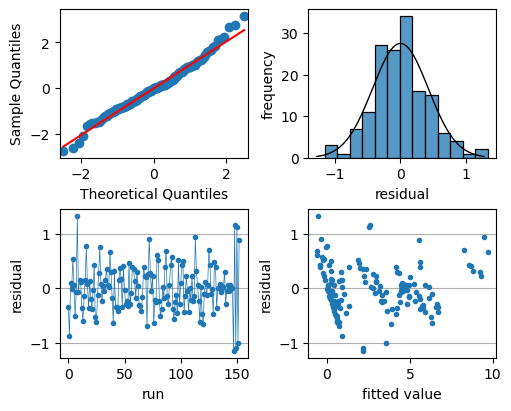

In [13]:
with Figure(5, 4, 2, 2) as (fig, ax):
    mqr.plot.regression.residuals(model_axial, axs=ax)
    plot = grab_figure(fig)

hstack(
    plot,
    vstack(
        mqr.anova.adequacy(model_axial),
        mqr.inference.dist.test_1sample(model_axial.resid)
    )
)


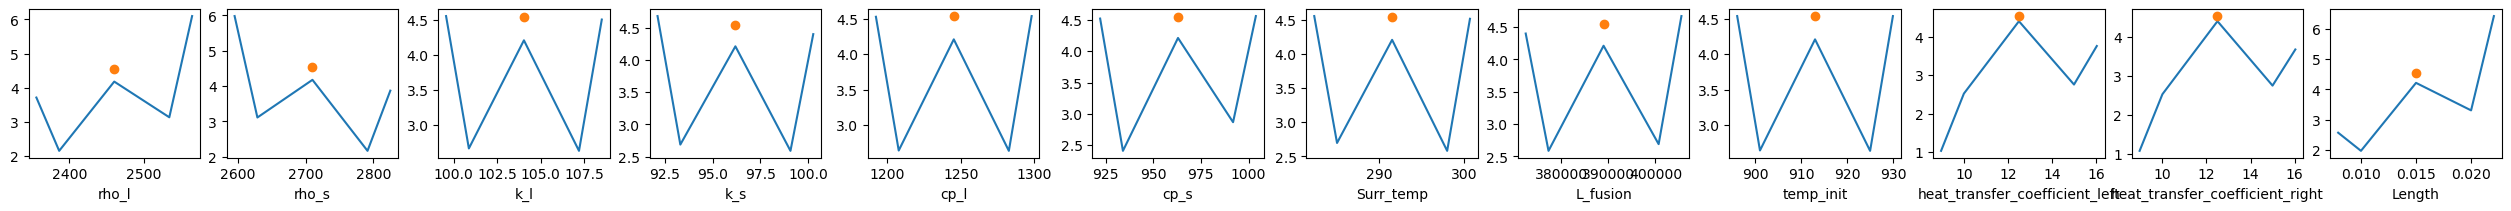

In [14]:
effect = 'Lowest_Niyama'
var_list = doe_axial.columns[0:12]

cornerdata = doe_axial.query('center_pt == 0')
centerdata = doe_axial.query('center_pt == 1')

with Figure(25, 2, 1, len(var_list)) as (fig, axs):
    for name, ax in zip(var_list, axs):
        ax.plot(cornerdata.groupby(name).mean()[effect], color='C0')
        ax.plot(centerdata.groupby(name).mean()[effect], color='C1', marker='o')
        ax.set_xlabel(name)
        plot1 = grab_figure(fig)

plot1

In [15]:
formula12 = 'Lowest_Niyama ~ rho_l + rho_s + k_l +k_s  \
             + cp_l + cp_s +   temp_init + L_fusion + \
              Length +  heat_transfer_coefficient_left + heat_transfer_coefficient_right + \
            rho_l*rho_s +  rho_l*cp_s  +   \
             +  cp_l*temp_init +  \
            cp_s*Length    \
            + heat_transfer_coefficient_left*heat_transfer_coefficient_right + \
             np.power(heat_transfer_coefficient_left, 2) + \
                np.power(heat_transfer_coefficient_right, 2) '


model_axial2 = sm.OLS.from_formula(formula12, data=doe_axial.iloc[:]).fit()

mqr.anova.coeffs(model_axial2)
mqr.anova.summary(model_axial2)

,df,sum_sq,mean_sq,F,PR(>F)
rho_l,1.0,33.370799,33.370799,160.349529,1.172258e-24
rho_s,1.0,30.445286,30.445286,146.292185,3.176723e-23
k_l,1.0,0.039406,0.039406,0.189351,6.641574e-01
k_s,1.0,0.330595,0.330595,1.588538,2.097254e-01
cp_l,1.0,0.000577,0.000577,0.002770,9.581031e-01
cp_s,1.0,6.506684,6.506684,31.265171,1.214089e-07
temp_init,1.0,0.000928,0.000928,0.004459,9.468579e-01
L_fusion,1.0,0.374594,0.374594,1.799955,1.819871e-01
Length,1.0,62.671876,62.671876,301.143693,4.402793e-36
heat_transfer_coefficient_left,1.0,12.999587,12.999587,62.464123,8.827630e-13


In [16]:
# Extracting coefficients (terms) and their p-values
terms = model_axial2.params.index
coefficients = model_axial2.params.values
p_values = model_axial2.pvalues.values

# Combine terms, coefficients, and p-values into a DataFrame
terms_pvalues_df = pd.DataFrame({
    'Term': terms,
    
    'P-Value': p_values
})
# print(terms_pvalues_df)
p_value_threshold = 0.05
significant_terms = terms_pvalues_df.loc[terms_pvalues_df['P-Value'] <= p_value_threshold]
print(significant_terms) 

                                                 Term       P-Value
0                                           Intercept  5.612351e-03
1                                               rho_l  3.611971e-17
2                                               rho_s  1.140715e-08
5                                                cp_l  6.332393e-18
6                                                cp_s  4.885831e-45
7                                           temp_init  6.511069e-18
9                                              Length  1.270666e-22
12                                        rho_l:rho_s  1.911983e-09
13                                         rho_l:cp_s  3.216034e-43
14                                     cp_l:temp_init  6.277036e-18
15                                        cp_s:Length  6.240302e-24
16  heat_transfer_coefficient_left:heat_transfer_c...  2.620614e-96
17        np.power(heat_transfer_coefficient_left, 2)  1.610390e-12
18       np.power(heat_transfer_coefficient_righ


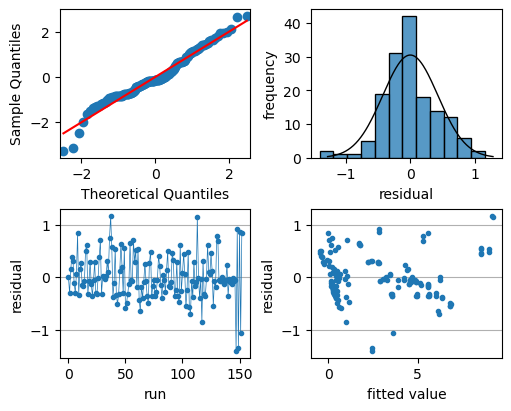

In [17]:
with Figure(5, 4, 2, 2) as (fig, ax):
    mqr.plot.regression.residuals(model_axial2, axs=ax)
    plot = grab_figure(fig)

hstack(
    plot,
    vstack(
        mqr.anova.adequacy(model_axial2),
        mqr.inference.dist.test_1sample(model_axial2.resid)
    )
)

In [18]:
anova_table = sm.stats.anova_lm(model_axial2, typ=2)
print(anova_table)

                                                        sum_sq     df  \
rho_l                                                33.370799    1.0   
rho_s                                                30.445286    1.0   
k_l                                                   0.039406    1.0   
k_s                                                   0.330595    1.0   
cp_l                                                  0.000577    1.0   
cp_s                                                  6.506684    1.0   
temp_init                                             0.000928    1.0   
L_fusion                                              0.374594    1.0   
Length                                               62.671876    1.0   
heat_transfer_coefficient_left                       12.999587    1.0   
heat_transfer_coefficient_right                      13.240097    1.0   
rho_l:rho_s                                           8.647601    1.0   
rho_l:cp_s                                         

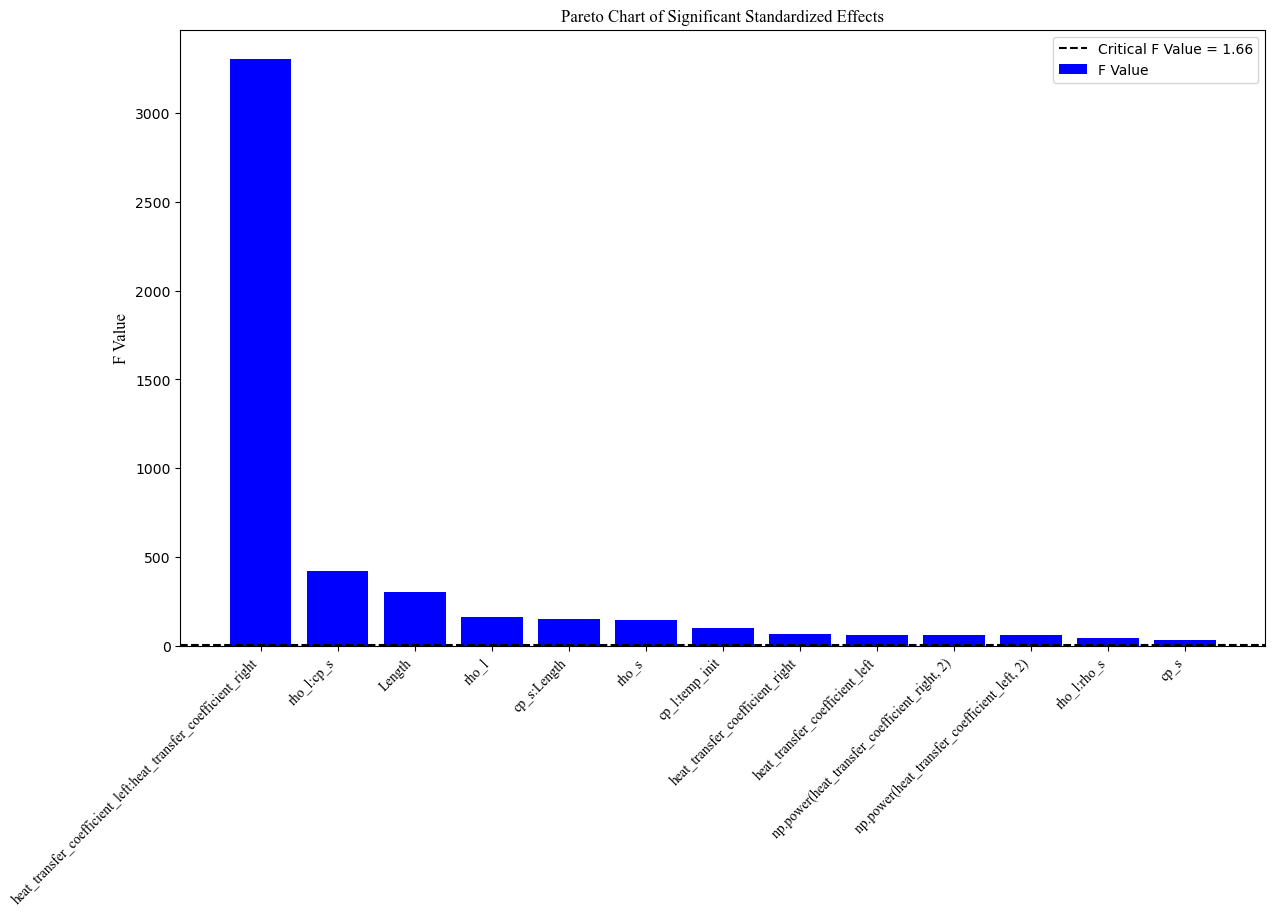

In [19]:
# Pareto Plot from anova_table

# Extract the F-statistic and p-value from the ANOVA table
f_statistic = anova_table['F'].values

p_values = anova_table['PR(>F)'].values

# Calculate the critical F-value
alpha = 0.05
num_total_points = doe_axial.shape[0]
num_terms = len(p_values)
critical_f_value = stats.f.ppf(q=1-alpha, dfn=num_terms, dfd=num_total_points-num_terms)

# Create a DataFrame for the Pareto plot
pareto_df = pd.DataFrame({
    'Term': anova_table.index,
    'F Value': f_statistic,
    'P Value': p_values
})

# Filter only significant terms (those with P-Value < alpha)
significant_pareto_df = pareto_df[pareto_df['P Value'] < alpha]

# Sort the DataFrame by the absolute F-value in descending order for the significant terms
significant_pareto_df = significant_pareto_df.reindex(significant_pareto_df['F Value'].abs().sort_values(ascending=False).index)

# Plot the Pareto chart for significant terms only
plt.figure(figsize=(14, 8))
plt.bar(significant_pareto_df['Term'], significant_pareto_df['F Value'], color='b', label='F Value')
plt.axhline(critical_f_value, color='k', linestyle='--', label='Critical F Value = {:.2f}'.format(critical_f_value))
plt.xticks(fontsize=10, rotation=45, ha='right', fontname='Times New Roman')
plt.legend()
plt.title('Pareto Chart of Significant Standardized Effects', fontname='Times New Roman')
plt.ylabel('F Value', fontname='Times New Roman', fontsize=12)   
plt.show()

In [20]:

# function for model predictor



def Ny(x,model):
    x = pd.DataFrame([x], columns=factor_levels.keys())
    pred = model.predict(x)
    print(f"pred :{pred}")
    Ny_bad = np.abs(pred-3)
    print(f"Ny_bad: {Ny_bad}")
    return Ny_bad


x0 = [2460.0 , 2710.0, 104.0, 96.0, 1245.0, 962.0, 291.5, 388000.0, 913.0, 12.5, 12.5, 15.0e-3]


bds =[(2386.20, 2533.8), (2628.70, 2791.3), (100.88, 107.2), (93.31,99.08), (1207.94, 1282.65), (934.11, 991.89), (285.0,298.0), (377330,400670), (901.0, 925.0), (10.0, 15.0), (10.0, 15.0), (10.0e-3, 20.0e-3)]

# Constraint to ensure Ny <= 3
def cons_ny(x, model):
    return 3 - Ny(x, model)  # This ensures Ny <= 3

constraints = [
    
    {'type': 'eq', 'fun': lambda x:  x[8] - 913.0},
    {'type': 'eq', 'fun': lambda x:  x[9] - 12.5},
    {'type': 'eq', 'fun': lambda x:  x[10] - 12.5},
    {'type': 'eq', 'fun': lambda x:  x[11] - 15.0e-3},
    {'type': 'ineq', 'fun': lambda x: cons_ny(x, model_axial2)}
    
]

result = minimize(Ny, x0, args=(model_axial2), method='Nelder-Mead', bounds=bds, constraints=constraints,options={'disp': True})


/tmp/ipykernel_1462814/1060282385.py:33: RuntimeWarning: Method Nelder-Mead cannot handle constraints.
  result = minimize(Ny, x0, args=(model_axial2), method='Nelder-Mead', bounds=bds, constraints=constraints,options={'disp': True})


pred :0    4.597068
dtype: float64
Ny_bad: 0    1.597068
dtype: float64
pred :0    4.755115
dtype: float64
Ny_bad: 0    1.755115
dtype: float64
pred :0    4.436982
dtype: float64
Ny_bad: 0    1.436982
dtype: float64
pred :0    4.590507
dtype: float64
Ny_bad: 0    1.590507
dtype: float64
pred :0    4.573476
dtype: float64
Ny_bad: 0    1.573476
dtype: float64
pred :0    4.596338
dtype: float64
Ny_bad: 0    1.596338
dtype: float64
pred :0    4.68683
dtype: float64
Ny_bad: 0    1.68683
dtype: float64
pred :0    4.597068
dtype: float64
Ny_bad: 0    1.597068
dtype: float64
pred :0    4.624183
dtype: float64
Ny_bad: 0    1.624183
dtype: float64
pred :0    4.596535
dtype: float64
Ny_bad: 0    1.596535
dtype: float64
pred :0    4.571604
dtype: float64
Ny_bad: 0    1.571604
dtype: float64
pred :0    4.568915
dtype: float64
Ny_bad: 0    1.568915
dtype: float64
pred :0    4.697835
dtype: float64
Ny_bad: 0    1.697835
dtype: float64
pred :0    4.446575
dtype: float64
Ny_bad: 0    1.446575
dtype: fl

In [21]:
cr_matpar = {
       'rho_l': result.x[0], #A
    'rho_s': result.x[1], #B
    'k_l': result.x[2],    #C
    'k_s': result.x[3],      #D
    'cp_l': result.x[4], #E
    'cp_s': result.x[5],  #F
    'Surr_temp': result.x[6], #G
    'L_fusion': result.x[7], #H
          #M

}

print(cr_matpar)

{'rho_l': 2411.8865059905547, 'rho_s': 2776.5492035632997, 'k_l': 105.53520610699428, 'k_s': 97.97139931268993, 'cp_l': 1261.0973325292284, 'cp_s': 955.8162160248048, 'Surr_temp': 291.37207737909625, 'L_fusion': 385105.7610511946}


In [22]:
init_res = list(result.x)
print(init_res)

[2411.8865059905547, 2776.5492035632997, 105.53520610699428, 97.97139931268993, 1261.0973325292284, 955.8162160248048, 291.37207737909625, 385105.7610511946, 915.8889529985809, 11.44383006030572, 13.6369670433, 0.013423852045545626]


In [23]:
def Ny2(x,model):
    x = pd.DataFrame([x], columns=factor_levels.keys())
    pred = model.predict(x)
    Ny_bad = np.abs(pred - 5.0)
    return Ny_bad


a0 = np.array(init_res)

bds2 =[(2386.20, 2533.8), (2628.70, 2791.3), (100.88, 107.2), (93.31,99.08), (1207.94, 1282.65), (934.11, 991.89), (285.0,298.0), (377330,400670), (901.0, 925.0), (10.0, 15.0), (10.0, 15.0), (10.0e-3, 20.0e-3)]

constraints2 = [
    {'type': 'eq', 'fun': lambda x:  x[0] - 2533.8},
    {'type': 'eq', 'fun': lambda x:  x[1] - 2791.3},
    {'type': 'eq', 'fun': lambda x:  x[2] - 107.2},
    {'type': 'eq', 'fun': lambda x:  x[3] - 99.08},
    {'type': 'eq', 'fun': lambda x:  x[4] - 1245.8374744664675},
    {'type': 'eq', 'fun': lambda x:  x[5] - 934.11},
    {'type': 'eq', 'fun': lambda x:  x[6] - 291.5},
    {'type': 'eq', 'fun': lambda x:  x[7] - 387999.9233813509},
    {'type': 'eq', 'fun': lambda x:  x[11] - 15.0e-3},
]

result2 = minimize(Ny2, init_res, args=(model_axial2), method='Nelder-Mead', bounds=bds2, constraints=constraints2,options={'disp': True})

/tmp/ipykernel_1462814/785069371.py:24: RuntimeWarning: Method Nelder-Mead cannot handle constraints.
  result2 = minimize(Ny2, init_res, args=(model_axial2), method='Nelder-Mead', bounds=bds2, constraints=constraints2,options={'disp': True})


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 451
         Function evaluations: 862


In [24]:
act_prpar = {
       'temp_init': result2.x[8], #J
    'heat_transfer_coefficient_left': result2.x[9], #K
    'heat_transfer_coefficient_right': result2.x[10], #L
    

}

print(act_prpar)

cr_matpar2 = {
       'rho_l': result2.x[0], #A
    'rho_s': result2.x[1], #B
    'k_l': result2.x[2],    #C
    'k_s': result2.x[3],      #D
    'cp_l': result2.x[4], #E
    'cp_s': result2.x[5],  #F
    'Surr_temp': result2.x[6], #G
    'L_fusion': result2.x[7], #H
          #M

}

print(cr_matpar2)

{'temp_init': 903.8108369098904, 'heat_transfer_coefficient_left': 11.908235028433397, 'heat_transfer_coefficient_right': 11.825698766206013}
{'rho_l': 2507.522403964261, 'rho_s': 2648.943632910121, 'k_l': 105.49568591894638, 'k_s': 96.91146371396019, 'cp_l': 1265.4095828457496, 'cp_s': 947.1619952421943, 'Surr_temp': 291.5146354746814, 'L_fusion': 388982.61295288627}


In [25]:
new_para = list(result2.x)
new_para = np.array(new_para)
# print(new_para)
x1 = pd.DataFrame([new_para], columns=factor_levels.keys())
x2 = pd.DataFrame([a0], columns=factor_levels.keys())
pred2 = model_axial2.predict(x1)
pred3 = model_axial2.predict(x2)



new_data = [2533.8, 2628.7, 100.88, 93.31, 1207.94, 934.11, 285.0, 377330.0, 901.0, 15.0, 10.0, 0.02]
new_data = np.array(new_data)
new_Data = pd.DataFrame([new_data], columns=factor_levels.keys())
pred4 = model_axial2.predict(new_Data)

print(pred2)
print(pred3)


0    5.0
dtype: float64
0    3.0
dtype: float64
